### Training Deep Networks from Zero to Hero: avoiding pitfalls and going beyond
#### A Tutorial presented at SIBGRAPI 2021

**Moacir Antonelli Ponti**, Fernando Pereira dos Santos, Leo Sampaio Ferraz Ribeiro, Gabriel Biscaro Cavallari

Paper (extended version): https://arxiv.org/abs/2109.02752

## Part 1 - How to Start

### Notebook 1 - **Data is important**
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print('Dataset size: ', x_train.shape)

Dataset size:  (404, 13)


## Naive approach

In [ ]:
# creating a validation set
x_sub = x_train[:-44]
y_sub = y_train[:-44]

x_val = x_train[-44:]
y_val = y_train[-44:]

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu", input_shape=(x_train.shape[1],)),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(1, activation="relu"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [ ]:
batch_size = 16
epochs = 250
history = model.fit(x_sub, y_sub,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=(x_val, y_val), verbose=0)

In [ ]:
score = model.evaluate(x_sub,y_sub, verbose=0)
print('Accuracy : ', score[1])
print('MSE : ', score[0])

Accuracy :  0.0
MSE :  346.29010009765625


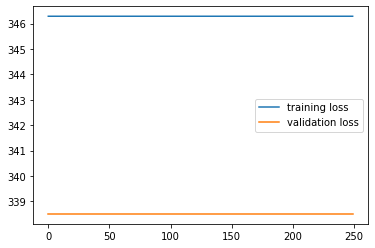

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

Wrong loss function!

Let us start over...

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu", input_shape=(x_train.shape[1],)),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(1, activation="relu"),
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                224       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


Now we use an Error function as loss!

In [ ]:
model.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [ ]:
batch_size = 16
epochs = 250
history = model.fit(x_sub, y_sub,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=(x_val, y_val), verbose=0)

In [ ]:
score = model.evaluate(x_sub,y_sub, verbose=0)
print('Accuracy : ', score[1])
print('MSE : ', score[0])

Accuracy :  0.0
MSE :  10.289143562316895


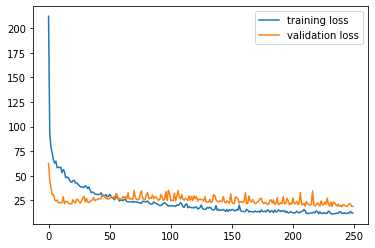

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

In [ ]:
score = model.evaluate(x_val,y_val, verbose=0)
print('Accuracy : ', score[1])
print('MSE : ', score[0])

Accuracy :  0.0
MSE :  19.0357723236084


Looks like the model saturates around squared error = 10

But: **what does it mean?**
- The target value is "Median value of owner-occupied homes in $1000s"

1. Accuracy makes **no sense here**: let's get rid of it. Maybe use another error measure?
2. MSE is a squared measure, to understand the real scale we should get the squared root of it

In [ ]:
from math import sqrt

scoreT = model.evaluate(x_sub,y_sub, verbose=0)
print('Accuracy : ', scoreT[1])
print('RMSE : ', sqrt(scoreT[0]))

scoreV = model.evaluate(x_val,y_val, verbose=0)
print('Accuracy : ', scoreV[1])
print('RMSE : ', sqrt(scoreV[0]))

Accuracy :  0.0
RMSE :  3.2076694908167975
Accuracy :  0.0
RMSE :  4.363000380885659


We are diverging $3$k in training and more than $4$k in the median value... can we improve it?

## 1) Know your data!

In [ ]:
import seaborn as sns

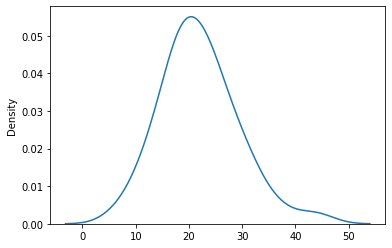

In [ ]:
sns.kdeplot(y_val)

In [ ]:
len(x_val.T)

13

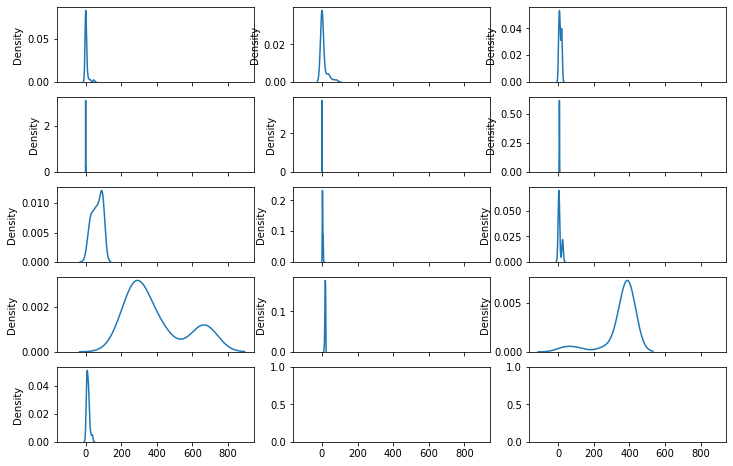

In [ ]:
# plotting the input data
fig, axes = plt.subplots(5, 3, sharex=True, figsize=(12,8))
for i, ax in zip(range(len(x_val.T)), axes.flat):
    sns.kdeplot(x_val.T[i,:], ax=ax)

The variable ranges are quite different! Let us scale it.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fit is performed only to the training set
tra_sc = scaler.fit_transform(x_sub)
# to the validation (and other future data) just transform
val_sc = scaler.transform(x_val)

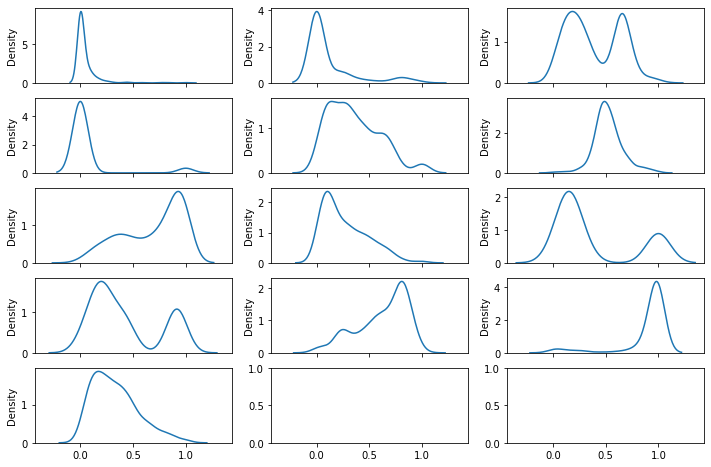

In [ ]:
fig, axes = plt.subplots(5, 3, sharex=True, figsize=(12,8))
for i, ax in zip(range(len(tra_sc.T)), axes.flat):
    sns.kdeplot(tra_sc.T[i,:], ax=ax)

In [ ]:
model2 = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu", input_shape=(x_train.shape[1],)),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(1, activation="relu"),
    ]
)

# now including Mean Absolute Error!
model2.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['mae'])

In [ ]:
history2 = model2.fit(tra_sc, y_sub,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=(val_sc,y_val), verbose=0)

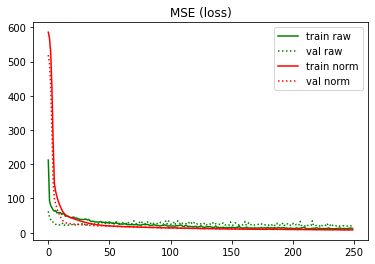

In [ ]:
plt.plot(history.history['loss'], 'g-', label='train raw')
plt.plot(history.history['val_loss'], 'g:', label='val raw')
plt.plot(history2.history['loss'], 'r-', label='train norm')
plt.plot(history2.history['val_loss'], 'r:', label='val norm')
plt.title('MSE (loss)')
plt.legend()

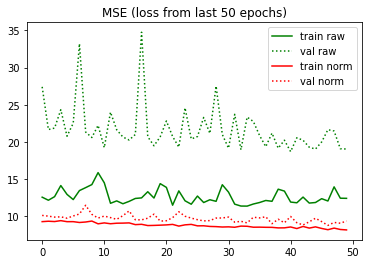

In [ ]:
plt.plot(history.history['loss'][-50:], 'g-', label='train raw')
plt.plot(history.history['val_loss'][-50:], 'g:', label='val raw')
plt.plot(history2.history['loss'][-50:], 'r-', label='train norm')
plt.plot(history2.history['val_loss'][-50:], 'r:', label='val norm')
plt.title('MSE (loss from last 50 epochs)')
plt.legend()

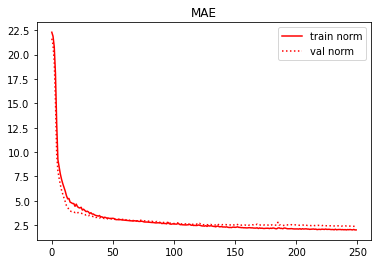

In [ ]:
plt.plot(history2.history['mae'], 'r-', label='train norm')
plt.plot(history2.history['val_mae'], 'r:', label='val norm')
plt.title('MAE')
plt.legend()

In [ ]:
scoreT2 = model2.evaluate(tra_sc, y_sub, verbose=0)
print('Training error')
print('MAE : ', scoreT2[1])
print('RMSE : ', sqrt(scoreT2[0]))

scoreV2 = model2.evaluate(val_sc, y_val, verbose=0)
print('Validation error')
print('MAE : ', scoreV2[1])
print('RMSE : ', sqrt(scoreV2[0]))

Training error
MAE :  1.9790184497833252
RMSE :  2.836541902224208
Validation error
MAE :  2.3768978118896484
RMSE :  3.058749958594867
